1.Lets install and invoke packages.

In [1]:
!pip install flair
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertForTokenClassification
import requests,os
from flair.datasets import ColumnCorpus
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from flair.data import Sentence
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

/home/sginne/anaconda3/envs/flair_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


expandable_segments:True


2-Loading tokenizers, models, etc

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=9)
train_url = 'https://raw.githubusercontent.com/lang-uk/flair-ner/main/fixed-split/train.iob'
test_url = 'https://raw.githubusercontent.com/lang-uk/flair-ner/main/fixed-split/test.iob'

def download_data(url, file_name):
    if not os.path.exists(file_name):
        response = requests.get(url)
        with open(file_name, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f'Data downloaded: {file_name}')
    else:
        print('Data found:', file_name)
data_folder = './data/'
os.makedirs(data_folder, exist_ok=True)
download_data(train_url, os.path.join(data_folder, 'train.iob'))
download_data(test_url, os.path.join(data_folder, 'test.iob'))

distilbert_embeddings = TransformerWordEmbeddings('distilbert-base-multilingual-cased', fine_tune=True)


/home/sginne/anaconda3/envs/flair_env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Data found: ./data/train.iob
Data found: ./data/test.iob


Lets make corpus

In [3]:
columns = {0: 'text', 1: 'ner'}
corpus = ColumnCorpus(data_folder, columns,
                      train_file='train.iob',
                      test_file='test.iob')
print(corpus)
for i in range(15):
    print(corpus.train[i])
tag_types = corpus.make_label_dictionary(label_type='ner')
print(tag_types)




2024-09-07 23:53:29,910 Reading data from data
2024-09-07 23:53:29,912 Train: data/train.iob
2024-09-07 23:53:29,913 Dev: None
2024-09-07 23:53:29,913 Test: data/test.iob
2024-09-07 23:53:32,649 No dev split found. Using 10% (i.e. 876 samples) of the train split as dev data
Corpus: 7886 train + 876 dev + 4045 test sentences
Sentence[18]: "Зрозуміло , що український бізнес почав використовувати КСВ як інструмент формування своєї репутації буквально декілька років тому ."
Sentence[22]: "З одного боку , саме через це більшість проектів КСВ здійснюються епізодично та деколи виглядають , радше , як просто благодійність ."
Sentence[8]: "Винятком будуть хіба що представництва іноземних корпорацій ."
Sentence[20]: "З іншого боку , для українських компаній відкривається потужне « вікно можливостей » , щоб втілювати власні унікальні стратегії ."
Sentence[3]: "Філантропія як пріоритет"
Sentence[15]: "Це може бути як власна ініціатива , так і відповідь на запит від громади ."
Sentence[17]: "Це абс

8it [00:00, 6633.93it/s]
7886it [00:00, 32802.54it/s]

2024-09-07 23:53:32,898 Dictionary created for label 'ner' with 4 values: PERS (seen 2408 times), LOC (seen 1087 times), ORG (seen 453 times), MISC (seen 373 times)
Dictionary with 4 tags: PERS, LOC, ORG, MISC


Lets make tagger and trainer

In [4]:
tagger = SequenceTagger(hidden_size=128,
                        embeddings=distilbert_embeddings,
                        tag_dictionary=tag_types,
                        tag_type='ner',
                        use_crf=False)
trainer = ModelTrainer(tagger, corpus)


2024-09-07 23:53:32,906 SequenceTagger predicts: Dictionary with 17 tags: O, S-PERS, B-PERS, E-PERS, I-PERS, S-LOC, B-LOC, E-LOC, I-LOC, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC


Model name and and model

In [5]:
finetuned_model_name='dist-finetuned.05'


In [6]:
trainer.train(finetuned_model_name,
              learning_rate=0.01,
              mini_batch_size=1,
              max_epochs=48,
              #embeddings_storage_mode='cpu',
              #main_evaluation_metric='f1',
              monitor_test=True,
              use_amp=False,
              train_with_dev=True) 

2024-09-07 23:53:39,051 ----------------------------------------------------------------------------------------------------
2024-09-07 23:53:39,053 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(119548, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_featu

/home/sginne/anaconda3/envs/flair_env/lib/python3.8/site-packages/flair/trainers/trainer.py:499: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp and flair.device.type != "cpu")


2024-09-07 23:54:35,008 epoch 1 - iter 876/8762 - loss 0.30177201 - time (sec): 55.94 - samples/sec: 288.02 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:55:26,159 epoch 1 - iter 1752/8762 - loss 0.25529109 - time (sec): 107.09 - samples/sec: 292.68 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:56:16,638 epoch 1 - iter 2628/8762 - loss 0.21538985 - time (sec): 157.57 - samples/sec: 295.24 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:57:07,196 epoch 1 - iter 3504/8762 - loss 0.19449142 - time (sec): 208.13 - samples/sec: 299.88 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:57:57,915 epoch 1 - iter 4380/8762 - loss 0.18189258 - time (sec): 258.85 - samples/sec: 303.79 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:58:48,780 epoch 1 - iter 5256/8762 - loss 0.17395712 - time (sec): 309.71 - samples/sec: 307.74 - lr: 0.010000 - momentum: 0.000000
2024-09-07 23:59:39,334 epoch 1 - iter 6132/8762 - loss 0.16982783 - time (sec): 360.26 - samples/sec: 309.24 - lr: 0.010000 -

100%|██████████| 64/64 [01:03<00:00,  1.01it/s]

2024-09-08 00:03:14,377 TEST : loss 0.1391058713197708 - f1-score (micro avg)  0.6948


2024-09-08 00:03:14,587  - 0 epochs without improvement
2024-09-08 00:03:14,588 ----------------------------------------------------------------------------------------------------
2024-09-08 00:04:05,333 epoch 2 - iter 876/8762 - loss 0.09334922 - time (sec): 50.74 - samples/sec: 306.66 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:04:56,167 epoch 2 - iter 1752/8762 - loss 0.11052437 - time (sec): 101.58 - samples/sec: 313.72 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:05:47,087 epoch 2 - iter 2628/8762 - loss 0.10017007 - time (sec): 152.50 - samples/sec: 315.05 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:06:37,756 epoch 2 - iter 3504/8762 - loss 0.09403462 - time (sec): 203.17 - samples/sec: 313.65 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:07:28,732 epoch 2 - iter 4380/8762 - loss 0.09662210 - time (sec): 254.14 - samples/sec: 313.29 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:08:19,404 epoch 2 - iter 5256/8762 - loss 0.09247689 - time (sec): 304.82 - s

100%|██████████| 64/64 [00:06<00:00, 10.31it/s]


2024-09-08 00:11:48,776 TEST : loss 0.13826881349086761 - f1-score (micro avg)  0.7256
2024-09-08 00:11:48,979  - 0 epochs without improvement
2024-09-08 00:11:48,980 ----------------------------------------------------------------------------------------------------
2024-09-08 00:12:39,773 epoch 3 - iter 876/8762 - loss 0.08108207 - time (sec): 50.79 - samples/sec: 310.45 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:13:30,750 epoch 3 - iter 1752/8762 - loss 0.07742904 - time (sec): 101.77 - samples/sec: 322.12 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:14:21,345 epoch 3 - iter 2628/8762 - loss 0.07891175 - time (sec): 152.36 - samples/sec: 317.01 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:15:12,340 epoch 3 - iter 3504/8762 - loss 0.07979293 - time (sec): 203.36 - samples/sec: 317.08 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:16:02,903 epoch 3 - iter 4380/8762 - loss 0.07427881 - time (sec): 253.92 - samples/sec: 314.98 - lr: 0.010000 - momentum: 0.000000
2024

100%|██████████| 64/64 [00:06<00:00, 10.48it/s]


2024-09-08 00:20:22,907 TEST : loss 0.13800208270549774 - f1-score (micro avg)  0.7194
2024-09-08 00:20:23,130  - 0 epochs without improvement
2024-09-08 00:20:23,131 ----------------------------------------------------------------------------------------------------
2024-09-08 00:21:13,739 epoch 4 - iter 876/8762 - loss 0.03751981 - time (sec): 50.61 - samples/sec: 311.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:22:04,682 epoch 4 - iter 1752/8762 - loss 0.04639005 - time (sec): 101.55 - samples/sec: 320.50 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:22:55,254 epoch 4 - iter 2628/8762 - loss 0.05312054 - time (sec): 152.12 - samples/sec: 316.83 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:23:46,542 epoch 4 - iter 3504/8762 - loss 0.05187477 - time (sec): 203.41 - samples/sec: 313.04 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:24:37,513 epoch 4 - iter 4380/8762 - loss 0.05208323 - time (sec): 254.38 - samples/sec: 312.05 - lr: 0.010000 - momentum: 0.000000
2024

100%|██████████| 64/64 [00:06<00:00, 10.34it/s]


2024-09-08 00:28:59,516 TEST : loss 0.1407155692577362 - f1-score (micro avg)  0.7136
2024-09-08 00:28:59,732  - 0 epochs without improvement
2024-09-08 00:28:59,733 ----------------------------------------------------------------------------------------------------
2024-09-08 00:29:50,997 epoch 5 - iter 876/8762 - loss 0.03714032 - time (sec): 51.26 - samples/sec: 316.78 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:30:42,319 epoch 5 - iter 1752/8762 - loss 0.04498555 - time (sec): 102.58 - samples/sec: 318.76 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:31:33,391 epoch 5 - iter 2628/8762 - loss 0.04185791 - time (sec): 153.65 - samples/sec: 313.15 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:32:24,748 epoch 5 - iter 3504/8762 - loss 0.04078193 - time (sec): 205.01 - samples/sec: 314.59 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:33:15,719 epoch 5 - iter 4380/8762 - loss 0.04098185 - time (sec): 255.98 - samples/sec: 312.99 - lr: 0.010000 - momentum: 0.000000
2024-

100%|██████████| 64/64 [00:06<00:00, 10.42it/s]


2024-09-08 00:37:36,574 TEST : loss 0.1478276401758194 - f1-score (micro avg)  0.7205
2024-09-08 00:37:36,780  - 0 epochs without improvement
2024-09-08 00:37:36,781 ----------------------------------------------------------------------------------------------------
2024-09-08 00:38:27,740 epoch 6 - iter 876/8762 - loss 0.03128049 - time (sec): 50.96 - samples/sec: 317.60 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:39:18,729 epoch 6 - iter 1752/8762 - loss 0.03222395 - time (sec): 101.95 - samples/sec: 313.79 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:40:09,798 epoch 6 - iter 2628/8762 - loss 0.03416298 - time (sec): 153.02 - samples/sec: 315.30 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:41:00,787 epoch 6 - iter 3504/8762 - loss 0.03500166 - time (sec): 204.01 - samples/sec: 314.04 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:41:51,607 epoch 6 - iter 4380/8762 - loss 0.03480739 - time (sec): 254.82 - samples/sec: 311.33 - lr: 0.010000 - momentum: 0.000000
2024-

100%|██████████| 64/64 [00:05<00:00, 11.70it/s]


2024-09-08 00:46:12,376 TEST : loss 0.15644781291484833 - f1-score (micro avg)  0.7223
2024-09-08 00:46:12,582  - 0 epochs without improvement
2024-09-08 00:46:12,583 ----------------------------------------------------------------------------------------------------
2024-09-08 00:47:03,468 epoch 7 - iter 876/8762 - loss 0.01685088 - time (sec): 50.88 - samples/sec: 304.05 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:47:54,497 epoch 7 - iter 1752/8762 - loss 0.02446325 - time (sec): 101.91 - samples/sec: 312.06 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:48:45,218 epoch 7 - iter 2628/8762 - loss 0.02714071 - time (sec): 152.63 - samples/sec: 307.78 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:49:36,247 epoch 7 - iter 3504/8762 - loss 0.02636813 - time (sec): 203.66 - samples/sec: 307.92 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:50:27,204 epoch 7 - iter 4380/8762 - loss 0.02579914 - time (sec): 254.62 - samples/sec: 309.44 - lr: 0.010000 - momentum: 0.000000
2024

100%|██████████| 64/64 [00:06<00:00, 10.58it/s]


2024-09-08 00:54:47,875 TEST : loss 0.16844964027404785 - f1-score (micro avg)  0.7145
2024-09-08 00:54:48,082  - 0 epochs without improvement
2024-09-08 00:54:48,083 ----------------------------------------------------------------------------------------------------
2024-09-08 00:55:38,871 epoch 8 - iter 876/8762 - loss 0.01886566 - time (sec): 50.79 - samples/sec: 305.10 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:56:29,731 epoch 8 - iter 1752/8762 - loss 0.02026685 - time (sec): 101.65 - samples/sec: 308.07 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:57:20,701 epoch 8 - iter 2628/8762 - loss 0.01796746 - time (sec): 152.62 - samples/sec: 311.13 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:58:11,480 epoch 8 - iter 3504/8762 - loss 0.01626772 - time (sec): 203.40 - samples/sec: 309.98 - lr: 0.010000 - momentum: 0.000000
2024-09-08 00:59:02,459 epoch 8 - iter 4380/8762 - loss 0.01832195 - time (sec): 254.37 - samples/sec: 311.12 - lr: 0.010000 - momentum: 0.000000
2024

100%|██████████| 64/64 [00:06<00:00, 10.41it/s]


2024-09-08 01:03:23,302 TEST : loss 0.17501312494277954 - f1-score (micro avg)  0.7154
2024-09-08 01:03:23,505  - 0 epochs without improvement
2024-09-08 01:03:23,525 ----------------------------------------------------------------------------------------------------
2024-09-08 01:04:14,605 epoch 9 - iter 876/8762 - loss 0.02064154 - time (sec): 51.08 - samples/sec: 323.56 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:05:05,618 epoch 9 - iter 1752/8762 - loss 0.01866504 - time (sec): 102.09 - samples/sec: 317.06 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:05:56,495 epoch 9 - iter 2628/8762 - loss 0.01648486 - time (sec): 152.97 - samples/sec: 316.91 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:06:47,247 epoch 9 - iter 3504/8762 - loss 0.01670474 - time (sec): 203.72 - samples/sec: 312.26 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:07:38,051 epoch 9 - iter 4380/8762 - loss 0.01628784 - time (sec): 254.53 - samples/sec: 311.70 - lr: 0.010000 - momentum: 0.000000
2024

100%|██████████| 64/64 [00:06<00:00, 10.39it/s]


2024-09-08 01:11:59,034 TEST : loss 0.18330664932727814 - f1-score (micro avg)  0.713
2024-09-08 01:11:59,239  - 0 epochs without improvement
2024-09-08 01:11:59,240 ----------------------------------------------------------------------------------------------------
2024-09-08 01:12:50,088 epoch 10 - iter 876/8762 - loss 0.01362153 - time (sec): 50.85 - samples/sec: 316.64 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:13:40,822 epoch 10 - iter 1752/8762 - loss 0.01185251 - time (sec): 101.58 - samples/sec: 313.44 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:14:31,701 epoch 10 - iter 2628/8762 - loss 0.01105096 - time (sec): 152.46 - samples/sec: 313.75 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:15:22,780 epoch 10 - iter 3504/8762 - loss 0.01078818 - time (sec): 203.54 - samples/sec: 313.63 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:16:13,348 epoch 10 - iter 4380/8762 - loss 0.01103157 - time (sec): 254.11 - samples/sec: 311.26 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.37it/s]


2024-09-08 01:20:35,444 TEST : loss 0.1914232075214386 - f1-score (micro avg)  0.7134
2024-09-08 01:20:35,651  - 0 epochs without improvement
2024-09-08 01:20:35,652 ----------------------------------------------------------------------------------------------------
2024-09-08 01:21:26,636 epoch 11 - iter 876/8762 - loss 0.00852322 - time (sec): 50.98 - samples/sec: 307.47 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:22:17,678 epoch 11 - iter 1752/8762 - loss 0.01019232 - time (sec): 102.02 - samples/sec: 303.04 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:23:08,908 epoch 11 - iter 2628/8762 - loss 0.01011164 - time (sec): 153.25 - samples/sec: 304.98 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:24:00,064 epoch 11 - iter 3504/8762 - loss 0.01083474 - time (sec): 204.41 - samples/sec: 306.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:24:51,359 epoch 11 - iter 4380/8762 - loss 0.01028662 - time (sec): 255.71 - samples/sec: 306.97 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.48it/s]


2024-09-08 01:29:13,041 TEST : loss 0.19788722693920135 - f1-score (micro avg)  0.716
2024-09-08 01:29:13,247  - 0 epochs without improvement
2024-09-08 01:29:13,248 ----------------------------------------------------------------------------------------------------
2024-09-08 01:30:04,270 epoch 12 - iter 876/8762 - loss 0.00400628 - time (sec): 51.02 - samples/sec: 310.93 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:30:55,036 epoch 12 - iter 1752/8762 - loss 0.00521081 - time (sec): 101.79 - samples/sec: 312.14 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:31:46,172 epoch 12 - iter 2628/8762 - loss 0.00750044 - time (sec): 152.92 - samples/sec: 318.60 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:32:37,151 epoch 12 - iter 3504/8762 - loss 0.00717098 - time (sec): 203.90 - samples/sec: 316.97 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:33:28,246 epoch 12 - iter 4380/8762 - loss 0.00851950 - time (sec): 255.00 - samples/sec: 317.43 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:05<00:00, 11.74it/s]


2024-09-08 01:37:48,211 TEST : loss 0.2047211229801178 - f1-score (micro avg)  0.7103
2024-09-08 01:37:48,421  - 0 epochs without improvement
2024-09-08 01:37:48,423 ----------------------------------------------------------------------------------------------------
2024-09-08 01:38:39,728 epoch 13 - iter 876/8762 - loss 0.00530208 - time (sec): 51.30 - samples/sec: 323.87 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:39:30,692 epoch 13 - iter 1752/8762 - loss 0.00617223 - time (sec): 102.27 - samples/sec: 317.16 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:40:21,884 epoch 13 - iter 2628/8762 - loss 0.00657900 - time (sec): 153.46 - samples/sec: 310.58 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:41:12,923 epoch 13 - iter 3504/8762 - loss 0.00613402 - time (sec): 204.50 - samples/sec: 311.07 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:42:04,017 epoch 13 - iter 4380/8762 - loss 0.00730045 - time (sec): 255.59 - samples/sec: 312.27 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.45it/s]


2024-09-08 01:46:24,753 TEST : loss 0.21056713163852692 - f1-score (micro avg)  0.7106
2024-09-08 01:46:24,957  - 0 epochs without improvement
2024-09-08 01:46:24,968 ----------------------------------------------------------------------------------------------------
2024-09-08 01:47:16,022 epoch 14 - iter 876/8762 - loss 0.00797454 - time (sec): 51.05 - samples/sec: 314.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:48:06,817 epoch 14 - iter 1752/8762 - loss 0.01011950 - time (sec): 101.85 - samples/sec: 306.80 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:48:57,875 epoch 14 - iter 2628/8762 - loss 0.00998342 - time (sec): 152.91 - samples/sec: 310.26 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:49:48,774 epoch 14 - iter 3504/8762 - loss 0.00839546 - time (sec): 203.80 - samples/sec: 311.86 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:50:39,861 epoch 14 - iter 4380/8762 - loss 0.00750846 - time (sec): 254.89 - samples/sec: 314.06 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.47it/s]


2024-09-08 01:55:00,280 TEST : loss 0.21504220366477966 - f1-score (micro avg)  0.7116
2024-09-08 01:55:00,482  - 0 epochs without improvement
2024-09-08 01:55:00,483 ----------------------------------------------------------------------------------------------------
2024-09-08 01:55:51,383 epoch 15 - iter 876/8762 - loss 0.00564954 - time (sec): 50.90 - samples/sec: 304.47 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:56:42,440 epoch 15 - iter 1752/8762 - loss 0.00590442 - time (sec): 101.96 - samples/sec: 312.56 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:57:33,244 epoch 15 - iter 2628/8762 - loss 0.00705828 - time (sec): 152.76 - samples/sec: 313.43 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:58:24,172 epoch 15 - iter 3504/8762 - loss 0.00592697 - time (sec): 203.69 - samples/sec: 314.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 01:59:15,293 epoch 15 - iter 4380/8762 - loss 0.00577035 - time (sec): 254.81 - samples/sec: 315.75 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.42it/s]


2024-09-08 02:03:35,904 TEST : loss 0.2225281149148941 - f1-score (micro avg)  0.7101
2024-09-08 02:03:36,109  - 0 epochs without improvement
2024-09-08 02:03:36,110 ----------------------------------------------------------------------------------------------------
2024-09-08 02:04:26,926 epoch 16 - iter 876/8762 - loss 0.00606164 - time (sec): 50.82 - samples/sec: 312.66 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:05:17,697 epoch 16 - iter 1752/8762 - loss 0.00493937 - time (sec): 101.59 - samples/sec: 311.26 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:06:08,485 epoch 16 - iter 2628/8762 - loss 0.00556711 - time (sec): 152.37 - samples/sec: 307.84 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:06:59,336 epoch 16 - iter 3504/8762 - loss 0.00533328 - time (sec): 203.22 - samples/sec: 308.17 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:07:50,277 epoch 16 - iter 4380/8762 - loss 0.00485537 - time (sec): 254.17 - samples/sec: 309.66 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.39it/s]

2024-09-08 02:12:11,264 TEST : loss 0.22711922228336334 - f1-score (micro avg)  0.7105


2024-09-08 02:12:11,475  - 0 epochs without improvement
2024-09-08 02:12:11,476 ----------------------------------------------------------------------------------------------------
2024-09-08 02:13:02,676 epoch 17 - iter 876/8762 - loss 0.00201853 - time (sec): 51.20 - samples/sec: 315.12 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:13:53,704 epoch 17 - iter 1752/8762 - loss 0.00294303 - time (sec): 102.23 - samples/sec: 309.67 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:14:44,871 epoch 17 - iter 2628/8762 - loss 0.00323313 - time (sec): 153.39 - samples/sec: 311.41 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:15:35,879 epoch 17 - iter 3504/8762 - loss 0.00270552 - time (sec): 204.40 - samples/sec: 307.74 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:16:27,264 epoch 17 - iter 4380/8762 - loss 0.00458862 - time (sec): 255.79 - samples/sec: 309.37 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:17:18,369 epoch 17 - iter 5256/8762 - loss 0.00451221 - time (sec): 306.

100%|██████████| 64/64 [00:05<00:00, 11.65it/s]


2024-09-08 02:20:49,039 TEST : loss 0.2293362021446228 - f1-score (micro avg)  0.7118
2024-09-08 02:20:49,249  - 1 epochs without improvement
2024-09-08 02:20:49,250 ----------------------------------------------------------------------------------------------------
2024-09-08 02:21:40,301 epoch 18 - iter 876/8762 - loss 0.01094939 - time (sec): 51.05 - samples/sec: 307.84 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:22:31,521 epoch 18 - iter 1752/8762 - loss 0.00641259 - time (sec): 102.27 - samples/sec: 317.62 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:23:22,463 epoch 18 - iter 2628/8762 - loss 0.00708323 - time (sec): 153.21 - samples/sec: 313.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:24:13,268 epoch 18 - iter 3504/8762 - loss 0.00597110 - time (sec): 204.02 - samples/sec: 309.17 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:25:04,206 epoch 18 - iter 4380/8762 - loss 0.00536778 - time (sec): 254.95 - samples/sec: 310.88 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.50it/s]


2024-09-08 02:29:25,357 TEST : loss 0.23227661848068237 - f1-score (micro avg)  0.7113
2024-09-08 02:29:25,558  - 2 epochs without improvement
2024-09-08 02:29:25,559 ----------------------------------------------------------------------------------------------------
2024-09-08 02:30:16,493 epoch 19 - iter 876/8762 - loss 0.00701901 - time (sec): 50.93 - samples/sec: 305.54 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:31:07,586 epoch 19 - iter 1752/8762 - loss 0.00514747 - time (sec): 102.03 - samples/sec: 312.93 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:31:58,606 epoch 19 - iter 2628/8762 - loss 0.00542279 - time (sec): 153.05 - samples/sec: 310.25 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:32:49,601 epoch 19 - iter 3504/8762 - loss 0.00519757 - time (sec): 204.04 - samples/sec: 309.89 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:33:40,610 epoch 19 - iter 4380/8762 - loss 0.00433393 - time (sec): 255.05 - samples/sec: 310.35 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.35it/s]


2024-09-08 02:38:02,287 TEST : loss 0.23535940051078796 - f1-score (micro avg)  0.7096
2024-09-08 02:38:02,527  - 0 epochs without improvement
2024-09-08 02:38:02,528 ----------------------------------------------------------------------------------------------------
2024-09-08 02:38:53,464 epoch 20 - iter 876/8762 - loss 0.00212075 - time (sec): 50.93 - samples/sec: 308.97 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:39:44,295 epoch 20 - iter 1752/8762 - loss 0.00300354 - time (sec): 101.77 - samples/sec: 308.03 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:40:35,254 epoch 20 - iter 2628/8762 - loss 0.00353622 - time (sec): 152.72 - samples/sec: 311.27 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:41:26,330 epoch 20 - iter 3504/8762 - loss 0.00343765 - time (sec): 203.80 - samples/sec: 310.89 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:42:17,444 epoch 20 - iter 4380/8762 - loss 0.00412236 - time (sec): 254.91 - samples/sec: 311.84 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.42it/s]


2024-09-08 02:46:38,814 TEST : loss 0.2377903014421463 - f1-score (micro avg)  0.7098
2024-09-08 02:46:39,017  - 0 epochs without improvement
2024-09-08 02:46:39,018 ----------------------------------------------------------------------------------------------------
2024-09-08 02:47:30,023 epoch 21 - iter 876/8762 - loss 0.00380028 - time (sec): 51.00 - samples/sec: 304.96 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:48:20,985 epoch 21 - iter 1752/8762 - loss 0.00277268 - time (sec): 101.97 - samples/sec: 298.26 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:49:12,113 epoch 21 - iter 2628/8762 - loss 0.00284333 - time (sec): 153.09 - samples/sec: 302.97 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:50:03,142 epoch 21 - iter 3504/8762 - loss 0.00268479 - time (sec): 204.12 - samples/sec: 305.24 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:50:54,338 epoch 21 - iter 4380/8762 - loss 0.00296676 - time (sec): 255.32 - samples/sec: 307.44 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.31it/s]


2024-09-08 02:55:16,257 TEST : loss 0.23921117186546326 - f1-score (micro avg)  0.7099
2024-09-08 02:55:16,462  - 0 epochs without improvement
2024-09-08 02:55:16,463 ----------------------------------------------------------------------------------------------------
2024-09-08 02:56:07,542 epoch 22 - iter 876/8762 - loss 0.00155426 - time (sec): 51.08 - samples/sec: 316.45 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:56:58,585 epoch 22 - iter 1752/8762 - loss 0.00392202 - time (sec): 102.12 - samples/sec: 312.33 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:57:49,701 epoch 22 - iter 2628/8762 - loss 0.00369183 - time (sec): 153.24 - samples/sec: 313.81 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:58:40,826 epoch 22 - iter 3504/8762 - loss 0.00359375 - time (sec): 204.36 - samples/sec: 313.26 - lr: 0.010000 - momentum: 0.000000
2024-09-08 02:59:31,892 epoch 22 - iter 4380/8762 - loss 0.00340098 - time (sec): 255.43 - samples/sec: 312.92 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.30it/s]


2024-09-08 03:03:53,684 TEST : loss 0.24207264184951782 - f1-score (micro avg)  0.7084
2024-09-08 03:03:53,892  - 0 epochs without improvement
2024-09-08 03:03:53,893 ----------------------------------------------------------------------------------------------------
2024-09-08 03:04:44,983 epoch 23 - iter 876/8762 - loss 0.00056239 - time (sec): 51.09 - samples/sec: 315.64 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:05:36,231 epoch 23 - iter 1752/8762 - loss 0.00144784 - time (sec): 102.34 - samples/sec: 311.79 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:06:27,764 epoch 23 - iter 2628/8762 - loss 0.00169624 - time (sec): 153.87 - samples/sec: 314.29 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:07:19,020 epoch 23 - iter 3504/8762 - loss 0.00145240 - time (sec): 205.13 - samples/sec: 311.41 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:08:10,378 epoch 23 - iter 4380/8762 - loss 0.00169269 - time (sec): 256.48 - samples/sec: 313.74 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:05<00:00, 11.49it/s]


2024-09-08 03:12:32,415 TEST : loss 0.24707721173763275 - f1-score (micro avg)  0.7098
2024-09-08 03:12:32,619  - 0 epochs without improvement
2024-09-08 03:12:32,620 ----------------------------------------------------------------------------------------------------
2024-09-08 03:13:24,014 epoch 24 - iter 876/8762 - loss 0.00086658 - time (sec): 51.39 - samples/sec: 309.19 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:14:15,211 epoch 24 - iter 1752/8762 - loss 0.00186404 - time (sec): 102.59 - samples/sec: 307.63 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:15:06,428 epoch 24 - iter 2628/8762 - loss 0.00153220 - time (sec): 153.81 - samples/sec: 308.52 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:15:57,912 epoch 24 - iter 3504/8762 - loss 0.00147841 - time (sec): 205.29 - samples/sec: 311.80 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:16:49,120 epoch 24 - iter 4380/8762 - loss 0.00162195 - time (sec): 256.50 - samples/sec: 312.48 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.50it/s]


2024-09-08 03:21:10,873 TEST : loss 0.24944230914115906 - f1-score (micro avg)  0.7111
2024-09-08 03:21:11,081  - 1 epochs without improvement
2024-09-08 03:21:11,082 ----------------------------------------------------------------------------------------------------
2024-09-08 03:22:02,014 epoch 25 - iter 876/8762 - loss 0.00294951 - time (sec): 50.93 - samples/sec: 296.68 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:22:53,164 epoch 25 - iter 1752/8762 - loss 0.00196933 - time (sec): 102.08 - samples/sec: 302.30 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:23:44,309 epoch 25 - iter 2628/8762 - loss 0.00217732 - time (sec): 153.23 - samples/sec: 306.59 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:24:35,672 epoch 25 - iter 3504/8762 - loss 0.00173263 - time (sec): 204.59 - samples/sec: 308.65 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:25:26,883 epoch 25 - iter 4380/8762 - loss 0.00207081 - time (sec): 255.80 - samples/sec: 309.05 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.28it/s]


2024-09-08 03:29:48,847 TEST : loss 0.25008106231689453 - f1-score (micro avg)  0.71
2024-09-08 03:29:49,055  - 0 epochs without improvement
2024-09-08 03:29:49,056 ----------------------------------------------------------------------------------------------------
2024-09-08 03:30:40,101 epoch 26 - iter 876/8762 - loss 0.00438135 - time (sec): 51.04 - samples/sec: 296.06 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:31:31,340 epoch 26 - iter 1752/8762 - loss 0.00331127 - time (sec): 102.28 - samples/sec: 305.59 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:32:22,294 epoch 26 - iter 2628/8762 - loss 0.00262988 - time (sec): 153.24 - samples/sec: 304.67 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:33:13,718 epoch 26 - iter 3504/8762 - loss 0.00225408 - time (sec): 204.66 - samples/sec: 307.13 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:34:04,868 epoch 26 - iter 4380/8762 - loss 0.00200063 - time (sec): 255.81 - samples/sec: 306.98 - lr: 0.010000 - momentum: 0.000000
2

100%|██████████| 64/64 [00:06<00:00, 10.17it/s]


2024-09-08 03:38:27,063 TEST : loss 0.2536834478378296 - f1-score (micro avg)  0.7125
2024-09-08 03:38:27,296  - 1 epochs without improvement
2024-09-08 03:38:27,297 ----------------------------------------------------------------------------------------------------
2024-09-08 03:39:18,318 epoch 27 - iter 876/8762 - loss 0.00095398 - time (sec): 51.02 - samples/sec: 312.39 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:40:09,711 epoch 27 - iter 1752/8762 - loss 0.00108334 - time (sec): 102.41 - samples/sec: 318.57 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:41:00,694 epoch 27 - iter 2628/8762 - loss 0.00116588 - time (sec): 153.40 - samples/sec: 312.65 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:41:51,628 epoch 27 - iter 3504/8762 - loss 0.00127970 - time (sec): 204.33 - samples/sec: 312.34 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:42:42,630 epoch 27 - iter 4380/8762 - loss 0.00134661 - time (sec): 255.33 - samples/sec: 312.40 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.33it/s]


2024-09-08 03:47:04,052 TEST : loss 0.2540872395038605 - f1-score (micro avg)  0.7144
2024-09-08 03:47:04,257  - 2 epochs without improvement
2024-09-08 03:47:04,258 ----------------------------------------------------------------------------------------------------
2024-09-08 03:47:55,429 epoch 28 - iter 876/8762 - loss 0.00054432 - time (sec): 51.17 - samples/sec: 307.54 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:48:46,789 epoch 28 - iter 1752/8762 - loss 0.00112108 - time (sec): 102.53 - samples/sec: 315.58 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:49:37,834 epoch 28 - iter 2628/8762 - loss 0.00173528 - time (sec): 153.58 - samples/sec: 314.48 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:50:29,045 epoch 28 - iter 3504/8762 - loss 0.00139758 - time (sec): 204.79 - samples/sec: 315.70 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:51:20,101 epoch 28 - iter 4380/8762 - loss 0.00156361 - time (sec): 255.84 - samples/sec: 315.18 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.20it/s]


2024-09-08 03:55:41,881 TEST : loss 0.2547137141227722 - f1-score (micro avg)  0.7123
2024-09-08 03:55:42,087  - 3 epochs without improvement
2024-09-08 03:55:42,088 ----------------------------------------------------------------------------------------------------
2024-09-08 03:56:33,055 epoch 29 - iter 876/8762 - loss 0.00141949 - time (sec): 50.97 - samples/sec: 306.71 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:57:24,271 epoch 29 - iter 1752/8762 - loss 0.00101102 - time (sec): 102.18 - samples/sec: 312.20 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:58:14,995 epoch 29 - iter 2628/8762 - loss 0.00108170 - time (sec): 152.91 - samples/sec: 311.03 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:59:06,779 epoch 29 - iter 3504/8762 - loss 0.00122683 - time (sec): 204.69 - samples/sec: 312.88 - lr: 0.010000 - momentum: 0.000000
2024-09-08 03:59:58,198 epoch 29 - iter 4380/8762 - loss 0.00131362 - time (sec): 256.11 - samples/sec: 310.85 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:05<00:00, 11.60it/s]


2024-09-08 04:04:20,869 TEST : loss 0.2596758306026459 - f1-score (micro avg)  0.7146
2024-09-08 04:04:21,075  - 0 epochs without improvement
2024-09-08 04:04:21,076 ----------------------------------------------------------------------------------------------------
2024-09-08 04:05:12,483 epoch 30 - iter 876/8762 - loss 0.00085035 - time (sec): 51.41 - samples/sec: 312.52 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:06:03,856 epoch 30 - iter 1752/8762 - loss 0.00101702 - time (sec): 102.78 - samples/sec: 313.97 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:06:55,239 epoch 30 - iter 2628/8762 - loss 0.00081360 - time (sec): 154.16 - samples/sec: 314.63 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:07:46,481 epoch 30 - iter 3504/8762 - loss 0.00113409 - time (sec): 205.40 - samples/sec: 309.00 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:08:37,789 epoch 30 - iter 4380/8762 - loss 0.00109226 - time (sec): 256.71 - samples/sec: 308.39 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.43it/s]


2024-09-08 04:13:00,547 TEST : loss 0.26074472069740295 - f1-score (micro avg)  0.712
2024-09-08 04:13:00,773  - 0 epochs without improvement
2024-09-08 04:13:00,774 ----------------------------------------------------------------------------------------------------
2024-09-08 04:13:51,916 epoch 31 - iter 876/8762 - loss 0.00126101 - time (sec): 51.14 - samples/sec: 304.32 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:14:43,183 epoch 31 - iter 1752/8762 - loss 0.00067733 - time (sec): 102.41 - samples/sec: 306.06 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:15:34,562 epoch 31 - iter 2628/8762 - loss 0.00056384 - time (sec): 153.79 - samples/sec: 307.77 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:16:25,879 epoch 31 - iter 3504/8762 - loss 0.00044365 - time (sec): 205.10 - samples/sec: 307.96 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:17:17,237 epoch 31 - iter 4380/8762 - loss 0.00052392 - time (sec): 256.46 - samples/sec: 309.01 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.29it/s]


2024-09-08 04:21:39,946 TEST : loss 0.26342907547950745 - f1-score (micro avg)  0.7107
2024-09-08 04:21:40,151  - 1 epochs without improvement
2024-09-08 04:21:40,152 ----------------------------------------------------------------------------------------------------
2024-09-08 04:22:31,585 epoch 32 - iter 876/8762 - loss 0.00121309 - time (sec): 51.43 - samples/sec: 325.56 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:23:22,895 epoch 32 - iter 1752/8762 - loss 0.00077247 - time (sec): 102.74 - samples/sec: 314.94 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:24:14,057 epoch 32 - iter 2628/8762 - loss 0.00065944 - time (sec): 153.90 - samples/sec: 311.90 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:25:05,150 epoch 32 - iter 3504/8762 - loss 0.00101818 - time (sec): 205.00 - samples/sec: 309.56 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:25:56,564 epoch 32 - iter 4380/8762 - loss 0.00088239 - time (sec): 256.41 - samples/sec: 313.20 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.25it/s]


2024-09-08 04:30:18,486 TEST : loss 0.26511675119400024 - f1-score (micro avg)  0.7102
2024-09-08 04:30:18,690  - 2 epochs without improvement
2024-09-08 04:30:18,691 ----------------------------------------------------------------------------------------------------
2024-09-08 04:31:09,731 epoch 33 - iter 876/8762 - loss 0.00213946 - time (sec): 51.04 - samples/sec: 308.51 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:32:00,870 epoch 33 - iter 1752/8762 - loss 0.00139515 - time (sec): 102.18 - samples/sec: 308.92 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:32:52,050 epoch 33 - iter 2628/8762 - loss 0.00166149 - time (sec): 153.36 - samples/sec: 312.03 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:33:43,263 epoch 33 - iter 3504/8762 - loss 0.00132970 - time (sec): 204.57 - samples/sec: 310.03 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:34:34,335 epoch 33 - iter 4380/8762 - loss 0.00119763 - time (sec): 255.64 - samples/sec: 309.44 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.33it/s]


2024-09-08 04:38:56,506 TEST : loss 0.26626768708229065 - f1-score (micro avg)  0.7089
2024-09-08 04:38:56,711  - 3 epochs without improvement
2024-09-08 04:38:56,713 ----------------------------------------------------------------------------------------------------
2024-09-08 04:39:47,995 epoch 34 - iter 876/8762 - loss 0.00164994 - time (sec): 51.28 - samples/sec: 316.88 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:40:39,266 epoch 34 - iter 1752/8762 - loss 0.00104935 - time (sec): 102.55 - samples/sec: 318.02 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:41:30,242 epoch 34 - iter 2628/8762 - loss 0.00075213 - time (sec): 153.53 - samples/sec: 310.67 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:42:21,303 epoch 34 - iter 3504/8762 - loss 0.00072669 - time (sec): 204.59 - samples/sec: 312.37 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:43:12,184 epoch 34 - iter 4380/8762 - loss 0.00065052 - time (sec): 255.47 - samples/sec: 310.11 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:05<00:00, 11.61it/s]


2024-09-08 04:47:33,642 TEST : loss 0.2678806781768799 - f1-score (micro avg)  0.711
2024-09-08 04:47:33,850  - 0 epochs without improvement
2024-09-08 04:47:33,851 ----------------------------------------------------------------------------------------------------
2024-09-08 04:48:24,839 epoch 35 - iter 876/8762 - loss 0.00119094 - time (sec): 50.99 - samples/sec: 302.91 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:49:15,995 epoch 35 - iter 1752/8762 - loss 0.00107521 - time (sec): 102.14 - samples/sec: 308.87 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:50:07,230 epoch 35 - iter 2628/8762 - loss 0.00084829 - time (sec): 153.38 - samples/sec: 310.21 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:50:58,410 epoch 35 - iter 3504/8762 - loss 0.00088644 - time (sec): 204.56 - samples/sec: 311.91 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:51:49,339 epoch 35 - iter 4380/8762 - loss 0.00075071 - time (sec): 255.49 - samples/sec: 309.58 - lr: 0.010000 - momentum: 0.000000
2

100%|██████████| 64/64 [00:06<00:00, 10.32it/s]


2024-09-08 04:56:12,515 TEST : loss 0.2684774100780487 - f1-score (micro avg)  0.7093
2024-09-08 04:56:12,725  - 1 epochs without improvement
2024-09-08 04:56:12,726 ----------------------------------------------------------------------------------------------------
2024-09-08 04:57:03,947 epoch 36 - iter 876/8762 - loss 0.00239884 - time (sec): 51.22 - samples/sec: 300.73 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:57:55,374 epoch 36 - iter 1752/8762 - loss 0.00180789 - time (sec): 102.65 - samples/sec: 305.67 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:58:46,604 epoch 36 - iter 2628/8762 - loss 0.00123874 - time (sec): 153.88 - samples/sec: 306.73 - lr: 0.010000 - momentum: 0.000000
2024-09-08 04:59:38,058 epoch 36 - iter 3504/8762 - loss 0.00125768 - time (sec): 205.33 - samples/sec: 307.96 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:00:29,481 epoch 36 - iter 4380/8762 - loss 0.00114986 - time (sec): 256.75 - samples/sec: 307.33 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.35it/s]


2024-09-08 05:04:52,274 TEST : loss 0.2706417143344879 - f1-score (micro avg)  0.7112
2024-09-08 05:04:52,481  - 2 epochs without improvement
2024-09-08 05:04:52,482 ----------------------------------------------------------------------------------------------------
2024-09-08 05:05:43,764 epoch 37 - iter 876/8762 - loss 0.00096496 - time (sec): 51.28 - samples/sec: 312.11 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:06:35,085 epoch 37 - iter 1752/8762 - loss 0.00183427 - time (sec): 102.60 - samples/sec: 307.15 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:07:26,404 epoch 37 - iter 2628/8762 - loss 0.00169453 - time (sec): 153.92 - samples/sec: 304.23 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:08:17,820 epoch 37 - iter 3504/8762 - loss 0.00151258 - time (sec): 205.34 - samples/sec: 308.52 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:09:09,183 epoch 37 - iter 4380/8762 - loss 0.00129020 - time (sec): 256.70 - samples/sec: 308.75 - lr: 0.010000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.27it/s]


2024-09-08 05:13:31,703 TEST : loss 0.27065548300743103 - f1-score (micro avg)  0.7132
2024-09-08 05:13:31,912  - 3 epochs without improvement
2024-09-08 05:13:31,914 ----------------------------------------------------------------------------------------------------
2024-09-08 05:14:23,135 epoch 38 - iter 876/8762 - loss 0.00048701 - time (sec): 51.22 - samples/sec: 304.78 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:15:14,221 epoch 38 - iter 1752/8762 - loss 0.00043514 - time (sec): 102.31 - samples/sec: 301.95 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:16:05,378 epoch 38 - iter 2628/8762 - loss 0.00035619 - time (sec): 153.46 - samples/sec: 303.62 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:16:56,530 epoch 38 - iter 3504/8762 - loss 0.00036290 - time (sec): 204.62 - samples/sec: 304.28 - lr: 0.010000 - momentum: 0.000000
2024-09-08 05:17:47,889 epoch 38 - iter 4380/8762 - loss 0.00036103 - time (sec): 255.97 - samples/sec: 308.13 - lr: 0.010000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.30it/s]


2024-09-08 05:22:10,827 TEST : loss 0.2701530456542969 - f1-score (micro avg)  0.7116
2024-09-08 05:22:11,035  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.005]
2024-09-08 05:22:11,036 ----------------------------------------------------------------------------------------------------
2024-09-08 05:23:02,260 epoch 39 - iter 876/8762 - loss 0.00143313 - time (sec): 51.22 - samples/sec: 308.49 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:23:53,701 epoch 39 - iter 1752/8762 - loss 0.00172971 - time (sec): 102.66 - samples/sec: 314.21 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:24:44,963 epoch 39 - iter 2628/8762 - loss 0.00119205 - time (sec): 153.93 - samples/sec: 312.77 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:25:36,228 epoch 39 - iter 3504/8762 - loss 0.00137961 - time (sec): 205.19 - samples/sec: 311.42 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:26:27,483 epoch 39 - iter 4380/8762 - loss 0.00115738 - time (sec): 256.45 - 

100%|██████████| 64/64 [00:06<00:00, 10.23it/s]


2024-09-08 05:30:50,127 TEST : loss 0.26981252431869507 - f1-score (micro avg)  0.7101
2024-09-08 05:30:50,331  - 1 epochs without improvement
2024-09-08 05:30:50,332 ----------------------------------------------------------------------------------------------------
2024-09-08 05:31:41,531 epoch 40 - iter 876/8762 - loss 0.00020332 - time (sec): 51.20 - samples/sec: 301.14 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:32:32,922 epoch 40 - iter 1752/8762 - loss 0.00028703 - time (sec): 102.59 - samples/sec: 303.74 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:33:24,493 epoch 40 - iter 2628/8762 - loss 0.00039163 - time (sec): 154.16 - samples/sec: 307.43 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:34:15,868 epoch 40 - iter 3504/8762 - loss 0.00036218 - time (sec): 205.54 - samples/sec: 307.01 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:35:07,313 epoch 40 - iter 4380/8762 - loss 0.00036594 - time (sec): 256.98 - samples/sec: 307.50 - lr: 0.005000 - momentum: 0.000000

100%|██████████| 64/64 [00:05<00:00, 11.50it/s]


2024-09-08 05:39:29,935 TEST : loss 0.2705116868019104 - f1-score (micro avg)  0.7115
2024-09-08 05:39:30,144  - 0 epochs without improvement
2024-09-08 05:39:30,145 ----------------------------------------------------------------------------------------------------
2024-09-08 05:40:21,439 epoch 41 - iter 876/8762 - loss 0.00099852 - time (sec): 51.29 - samples/sec: 303.28 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:41:12,838 epoch 41 - iter 1752/8762 - loss 0.00056813 - time (sec): 102.69 - samples/sec: 307.73 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:42:04,366 epoch 41 - iter 2628/8762 - loss 0.00071978 - time (sec): 154.22 - samples/sec: 311.27 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:42:55,732 epoch 41 - iter 3504/8762 - loss 0.00076019 - time (sec): 205.59 - samples/sec: 310.61 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:43:47,250 epoch 41 - iter 4380/8762 - loss 0.00064816 - time (sec): 257.10 - samples/sec: 310.75 - lr: 0.005000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.42it/s]


2024-09-08 05:48:10,264 TEST : loss 0.2722858786582947 - f1-score (micro avg)  0.711
2024-09-08 05:48:10,471  - 1 epochs without improvement
2024-09-08 05:48:10,474 ----------------------------------------------------------------------------------------------------
2024-09-08 05:49:01,924 epoch 42 - iter 876/8762 - loss 0.00025915 - time (sec): 51.45 - samples/sec: 310.57 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:49:53,266 epoch 42 - iter 1752/8762 - loss 0.00023137 - time (sec): 102.79 - samples/sec: 308.05 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:50:44,498 epoch 42 - iter 2628/8762 - loss 0.00021122 - time (sec): 154.02 - samples/sec: 308.04 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:51:35,478 epoch 42 - iter 3504/8762 - loss 0.00035747 - time (sec): 205.00 - samples/sec: 303.06 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:52:26,911 epoch 42 - iter 4380/8762 - loss 0.00052443 - time (sec): 256.43 - samples/sec: 302.28 - lr: 0.005000 - momentum: 0.000000
2

100%|██████████| 64/64 [00:06<00:00, 10.20it/s]


2024-09-08 05:56:50,592 TEST : loss 0.2730211317539215 - f1-score (micro avg)  0.712
2024-09-08 05:56:50,793  - 2 epochs without improvement
2024-09-08 05:56:50,794 ----------------------------------------------------------------------------------------------------
2024-09-08 05:57:41,931 epoch 43 - iter 876/8762 - loss 0.00069717 - time (sec): 51.14 - samples/sec: 299.87 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:58:33,103 epoch 43 - iter 1752/8762 - loss 0.00048023 - time (sec): 102.31 - samples/sec: 299.70 - lr: 0.005000 - momentum: 0.000000
2024-09-08 05:59:24,455 epoch 43 - iter 2628/8762 - loss 0.00049653 - time (sec): 153.66 - samples/sec: 306.27 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:00:15,567 epoch 43 - iter 3504/8762 - loss 0.00048496 - time (sec): 204.77 - samples/sec: 305.89 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:01:06,803 epoch 43 - iter 4380/8762 - loss 0.00051184 - time (sec): 256.01 - samples/sec: 306.42 - lr: 0.005000 - momentum: 0.000000
2

100%|██████████| 64/64 [00:06<00:00, 10.19it/s]


2024-09-08 06:05:29,709 TEST : loss 0.27350491285324097 - f1-score (micro avg)  0.7117
2024-09-08 06:05:29,910  - 0 epochs without improvement
2024-09-08 06:05:29,911 ----------------------------------------------------------------------------------------------------
2024-09-08 06:06:21,047 epoch 44 - iter 876/8762 - loss 0.00079172 - time (sec): 51.14 - samples/sec: 306.29 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:07:12,357 epoch 44 - iter 1752/8762 - loss 0.00077834 - time (sec): 102.44 - samples/sec: 311.33 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:08:03,569 epoch 44 - iter 2628/8762 - loss 0.00075675 - time (sec): 153.66 - samples/sec: 313.04 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:08:54,849 epoch 44 - iter 3504/8762 - loss 0.00062991 - time (sec): 204.94 - samples/sec: 313.80 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:09:46,096 epoch 44 - iter 4380/8762 - loss 0.00053553 - time (sec): 256.18 - samples/sec: 312.56 - lr: 0.005000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.27it/s]


2024-09-08 06:14:08,788 TEST : loss 0.27468904852867126 - f1-score (micro avg)  0.7117
2024-09-08 06:14:08,992  - 1 epochs without improvement
2024-09-08 06:14:08,993 ----------------------------------------------------------------------------------------------------
2024-09-08 06:15:00,292 epoch 45 - iter 876/8762 - loss 0.00036632 - time (sec): 51.30 - samples/sec: 316.42 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:15:51,750 epoch 45 - iter 1752/8762 - loss 0.00050613 - time (sec): 102.76 - samples/sec: 312.25 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:16:42,639 epoch 45 - iter 2628/8762 - loss 0.00046296 - time (sec): 153.64 - samples/sec: 306.34 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:17:33,872 epoch 45 - iter 3504/8762 - loss 0.00037897 - time (sec): 204.88 - samples/sec: 307.57 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:18:25,085 epoch 45 - iter 4380/8762 - loss 0.00054628 - time (sec): 256.09 - samples/sec: 309.18 - lr: 0.005000 - momentum: 0.000000

100%|██████████| 64/64 [00:06<00:00, 10.15it/s]


2024-09-08 06:22:47,762 TEST : loss 0.27500253915786743 - f1-score (micro avg)  0.712
2024-09-08 06:22:47,966  - 2 epochs without improvement
2024-09-08 06:22:47,967 ----------------------------------------------------------------------------------------------------
2024-09-08 06:23:39,059 epoch 46 - iter 876/8762 - loss 0.00029761 - time (sec): 51.09 - samples/sec: 307.32 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:24:30,361 epoch 46 - iter 1752/8762 - loss 0.00028711 - time (sec): 102.39 - samples/sec: 307.71 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:25:21,693 epoch 46 - iter 2628/8762 - loss 0.00022061 - time (sec): 153.72 - samples/sec: 308.14 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:26:12,867 epoch 46 - iter 3504/8762 - loss 0.00020178 - time (sec): 204.90 - samples/sec: 307.28 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:27:03,894 epoch 46 - iter 4380/8762 - loss 0.00020304 - time (sec): 255.93 - samples/sec: 306.35 - lr: 0.005000 - momentum: 0.000000


100%|██████████| 64/64 [00:05<00:00, 11.58it/s]


2024-09-08 06:31:25,320 TEST : loss 0.2747323215007782 - f1-score (micro avg)  0.7125
2024-09-08 06:31:25,524  - 0 epochs without improvement
2024-09-08 06:31:25,525 ----------------------------------------------------------------------------------------------------
2024-09-08 06:32:16,532 epoch 47 - iter 876/8762 - loss 0.00054086 - time (sec): 51.01 - samples/sec: 314.22 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:33:07,628 epoch 47 - iter 1752/8762 - loss 0.00048877 - time (sec): 102.10 - samples/sec: 304.70 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:33:58,856 epoch 47 - iter 2628/8762 - loss 0.00059414 - time (sec): 153.33 - samples/sec: 306.59 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:34:50,117 epoch 47 - iter 3504/8762 - loss 0.00045603 - time (sec): 204.59 - samples/sec: 308.50 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:35:41,275 epoch 47 - iter 4380/8762 - loss 0.00038453 - time (sec): 255.75 - samples/sec: 310.48 - lr: 0.005000 - momentum: 0.000000


100%|██████████| 64/64 [00:06<00:00, 10.38it/s]


2024-09-08 06:40:03,239 TEST : loss 0.275339812040329 - f1-score (micro avg)  0.7123
2024-09-08 06:40:03,443  - 1 epochs without improvement
2024-09-08 06:40:03,444 ----------------------------------------------------------------------------------------------------
2024-09-08 06:40:54,814 epoch 48 - iter 876/8762 - loss 0.00039788 - time (sec): 51.37 - samples/sec: 314.74 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:41:46,241 epoch 48 - iter 1752/8762 - loss 0.00071032 - time (sec): 102.80 - samples/sec: 314.49 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:42:37,609 epoch 48 - iter 2628/8762 - loss 0.00051673 - time (sec): 154.16 - samples/sec: 312.20 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:43:28,987 epoch 48 - iter 3504/8762 - loss 0.00049894 - time (sec): 205.54 - samples/sec: 311.79 - lr: 0.005000 - momentum: 0.000000
2024-09-08 06:44:20,443 epoch 48 - iter 4380/8762 - loss 0.00044996 - time (sec): 257.00 - samples/sec: 311.58 - lr: 0.005000 - momentum: 0.000000
2

100%|██████████| 64/64 [00:06<00:00, 10.05it/s]


2024-09-08 06:48:43,028 TEST : loss 0.27717503905296326 - f1-score (micro avg)  0.7119
2024-09-08 06:48:43,231  - 2 epochs without improvement
2024-09-08 06:48:48,573 ----------------------------------------------------------------------------------------------------
2024-09-08 06:48:48,605 Testing using last state of model ...


100%|██████████| 64/64 [00:06<00:00,  9.59it/s]


2024-09-08 06:48:56,290 
Results:
- F-score (micro) 0.7119
- F-score (macro) 0.4996
- Accuracy 0.6303

By class:
              precision    recall  f1-score   support

        PERS     0.9264    0.8248    0.8726      1678
         LOC     0.6012    0.7556    0.6696       401
         ORG     0.2873    0.6782    0.4036       261
        MISC     0.1231    0.0333    0.0525       240

   micro avg     0.6988    0.7256    0.7119      2580
   macro avg     0.4845    0.5730    0.4996      2580
weighted avg     0.7365    0.7256    0.7173      2580

2024-09-08 06:48:56,290 ----------------------------------------------------------------------------------------------------


{'test_score': 0.7119224187107815}

Lets evaluate it

In [7]:
result = tagger.evaluate(corpus.test, gold_label_type='ner')  # Evaluate on the test set
print(result.detailed_results)

100%|██████████| 127/127 [00:48<00:00,  2.61it/s]


Results:
- F-score (micro) 0.8194
- F-score (macro) 0.7011
- Accuracy 0.7506

By class:
              precision    recall  f1-score   support

        PERS     0.9090    0.8993    0.9041      1678
         LOC     0.7319    0.8304    0.7780       401
        MISC     0.5323    0.5500    0.5410       240
         ORG     0.6570    0.5211    0.5812       261

   micro avg     0.8210    0.8178    0.8194      2580
   macro avg     0.7075    0.7002    0.7011      2580
weighted avg     0.8210    0.8178    0.8181      2580



Lets test with own data

In [8]:
finetuned_model = SequenceTagger.load('/home/sginne/src/master_thesis/colab/'+finetuned_model_name+'/final-model.pt')
def print_tagged_sentences(sentences, model=None):
    # Load model only if not already loaded
    
    for text in sentences:
        sentence = Sentence(text)  # Create Sentence object
        model.predict(sentence)    # Predict tags
        #print (sentence.to_tagged_string())
        tagged_sentence = []
        spans=sentence.get_spans('ner')
    
        #for span in spans:
        #    print ("Span:",span.get_label('ner').value)
        #    print ("Span:",span.get_label('ner').score)
        i=0
        for token in sentence:
            if i!=len(spans):
                if (token==spans[i][0]):
                    current_tag_token=spans[i]
                    current_tag_value=current_tag_token.get_label('ner').value
                    current_tag_score=current_tag_token.get_label('ner').score
                    tagged_sentence.append(f'[{token.text}|({current_tag_value}={current_tag_score*100:.1f}%)]')
                    i=i+1
                else:
                    tagged_sentence.append(token.text)
            else:
                tagged_sentence.append(token.text)

        print ( ' '.join(tagged_sentence))

sentences = [
    'Привіт , мене звати Тімо і я живу в Турку , навчаюсь в Универсітеті Турку',
    'Тімо Юнолайнен живе в місті Турку й навчається в Університеті міста Турку.',
    'Місто Турку розташоване на південно-західному узбережжі Фінляндії.',
    'В Турку є поліція, й вона вельми корумпована',
    'У Турку проходить щорічний фестиваль музики та мистецтв.',
    'Тімо Юнолайнен, професор в Університеті міста Турку, співпрацює з організацією "Турку Інститут" для розробки нових проектів у Турку.'
]

print_tagged_sentences(sentences, finetuned_model)

2024-09-08 06:49:54,401 SequenceTagger predicts: Dictionary with 17 tags: O, S-PERS, B-PERS, E-PERS, I-PERS, S-LOC, B-LOC, E-LOC, I-LOC, S-ORG, B-ORG, E-ORG, I-ORG, S-MISC, B-MISC, E-MISC, I-MISC
Привіт , мене звати [Тімо|(PERS=100.0%)] і я живу в [Турку|(LOC=100.0%)] , навчаюсь в [Универсітеті|(ORG=99.8%)] Турку
Тімо [Юнолайнен|(PERS=100.0%)] живе в місті [Турку|(LOC=100.0%)] й навчається в [Університеті|(ORG=89.9%)] міста Турку .
Місто [Турку|(LOC=100.0%)] розташоване на південно-західному узбережжі [Фінляндії|(LOC=100.0%)] .
В [Турку|(LOC=100.0%)] є поліція , й вона вельми корумпована
У [Турку|(LOC=100.0%)] проходить щорічний фестиваль музики та мистецтв .
Тімо [Юнолайнен|(PERS=74.0%)] , професор в [Університеті|(ORG=99.8%)] міста Турку , співпрацює з організацією " [Турку|(ORG=100.0%)] Інститут " для розробки нових проектів у [Турку|(LOC=100.0%)] .


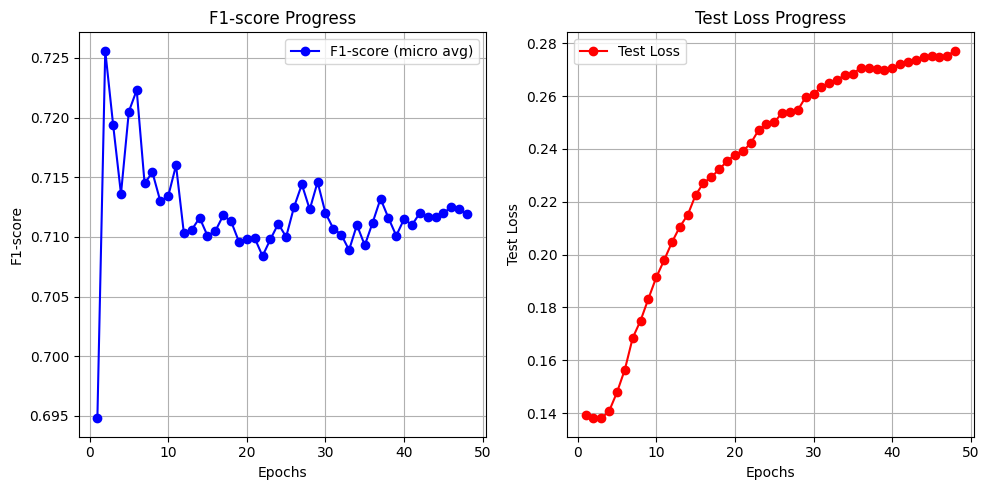

In [10]:
import re
import matplotlib.pyplot as plt

# Parse the log file
epochs = []
f1_scores = []
test_losses = []

with open('dist-finetuned.05/training.log', 'r') as f:
    for line in f:
        if 'EPOCH' in line and 'done' in line:
            epoch = int(re.search(r'EPOCH (\d+)', line).group(1))
            epochs.append(epoch)
        if 'TEST :' in line:
            test_loss = float(re.search(r'loss ([\d.]+)', line).group(1))
            test_losses.append(test_loss)
        if 'f1-score (micro avg)' in line:
            f1_score = float(re.search(r'f1-score \(micro avg\)\s+([\d.]+)', line).group(1))
            f1_scores.append(f1_score)

# Plotting the results
plt.figure(figsize=(10,5))

# F1-score plot
plt.subplot(1, 2, 1)
plt.plot(epochs, f1_scores, marker='o', color='b', label='F1-score (micro avg)')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score Progress')
plt.grid(True)
plt.legend()

# Test loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, test_losses, marker='o', color='r', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('Test Loss Progress')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
